<a href="https://colab.research.google.com/github/mfilipak/AFRAC_IA/blob/main/002_Embeddings1_Portal_da_Transpar%C3%AAncia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EM CONSTRUÇÃO

# Experimento 002
##Objetivo: Experimentos com word embeddings usando como corpo o campo de descrição do dataset público do portal da transparência.
###Descrição: Experimentos iniciais para criação e visualização de word embeddings

Dica: No COLAB Use CTRL SPACE ao invés de TAB para "autocompletar". Ex:pd.re [CTRL SPACE] vai mostrar uma lista contendo as funções e atributos que começam com pd.re (como read_csv, ...) 

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pprint

from gensim.models import Word2Vec
#from sentence_transformers import SentenceTransformer
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#1 - Carga do dataset

In [3]:
#Copia os dados das NFEs do portal da cidadância pro drive virtual.
import requests  
file_url = "https://raw.githubusercontent.com//mfilipak/AFRAC_IA/main/DATASET/202201_NFe_NotaFiscalItem.zip"
r = requests.get(file_url, stream = True) 

with open("portal.zip", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

DATA_FILE = "portal.zip"
df = pd.read_csv(DATA_FILE, encoding="CP1252",sep=";")
print("O dataframe completo contém:",len(df),"linhas")

O dataframe completo contém: 324056 linhas


In [4]:
df3 = df[['DATA EMISSÃO','DESCRIÇÃO DO PRODUTO/SERVIÇO', 'CÓDIGO NCM/SH', 'CFOP']]
df3.columns = ["DATA", "DESCR", "NCM", "CFOP"]
df3 = df3[df3["NCM"]!=-1] #Filtrando NCMs = -1

text_lengths = np.array([len(_) for _ in df3['DESCR']])
df3 = df3[text_lengths>=3]

#Caso queira eliminar as repetições rodar a linha abaixo
df3 = df3.drop_duplicates(subset=["DESCR"])

#2 - Carga do text corpus

In [5]:
#No jargão do doc2vec, cada descrição é um document e o conjunto de docs um corpus
#Link: https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py
random.seed(42)
#text_corpus = random.sample(list(df3["DESCR"]), 100)
text_corpus = random.sample(list(df3["DESCR"][:30]), 10)
text_corpus
#Deixar bem curtinho o corpo pra ir arrumando o código e testando os resultados. Pra sequência abaixo fazer mais sentido é bom que tenha alguma repetição de palavras

['GASOLINA COMUM',
 'MLTD203UXAZ CARTUCHO DE TONER PRETO 15K PAGINAS',
 'HP RESERVATORIO DE RESIDUO DE TONER',
 'UVA ITALIA',
 'CLTC603LXAZ CARTUCHO DE TONER CIANO 10K PAGINAS',
 'CARTUCHO DE TONER AMARELO 3.5K PAGINAS',
 'CENOURA',
 'CLTC506LXAZ CARTUCHO DE TONER CIANO 3.5K PAGINAS',
 'PLACA LED ILUMINACAO',
 'OLEO DIESEL B S10 ADITIVADO GRID']

#3 - Determinando as palavras muito frequentes 

In [6]:
all_words = []
for d in list(df3["DESCR"]):
    all_words += d.split()
words_counts = pd.DataFrame(all_words).value_counts()
print("Palavras mais frequentemente encontradas")
print(" ".join([_[0] for _ in words_counts.index[:30]]))

Palavras mais frequentemente encontradas
- DE E PARA X COM 1 EM TIPO de A | DO FILTRO C/ DA MM 2 / PARAFUSO CABO Lote: P/ OLEO 100 Ed O MATERIAL 10 KG


#4 - Seguindo com o tutorial do doc2vec (Que usa o modelo mais simples tf-idf)

In [7]:
stoplist = set('- DE E PARA X COM EM TIPO de A | DO C/ DA / P/ Ed O'.split(' '))

In [8]:
# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in text_corpus]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear more than once
#Ignorei esse filtro pois com poucos exemplos iria cortar quase tudo
processed_corpus = [[token for token in text if frequency[token] > 0] for text in texts]
pprint.pprint(processed_corpus)

[['gasolina', 'comum'],
 ['mltd203uxaz', 'cartucho', 'toner', 'preto', '15k', 'paginas'],
 ['hp', 'reservatorio', 'residuo', 'toner'],
 ['uva', 'italia'],
 ['cltc603lxaz', 'cartucho', 'toner', 'ciano', '10k', 'paginas'],
 ['cartucho', 'toner', 'amarelo', '3.5k', 'paginas'],
 ['cenoura'],
 ['cltc506lxaz', 'cartucho', 'toner', 'ciano', '3.5k', 'paginas'],
 ['placa', 'led', 'iluminacao'],
 ['oleo', 'diesel', 'b', 's10', 'aditivado', 'grid']]


In [9]:
processed_corpus[0] = processed_corpus[0]+processed_corpus[0] #Forcei uma palavra repetida na descrição somente para ter um exemplo
processed_corpus

[['gasolina', 'comum', 'gasolina', 'comum'],
 ['mltd203uxaz', 'cartucho', 'toner', 'preto', '15k', 'paginas'],
 ['hp', 'reservatorio', 'residuo', 'toner'],
 ['uva', 'italia'],
 ['cltc603lxaz', 'cartucho', 'toner', 'ciano', '10k', 'paginas'],
 ['cartucho', 'toner', 'amarelo', '3.5k', 'paginas'],
 ['cenoura'],
 ['cltc506lxaz', 'cartucho', 'toner', 'ciano', '3.5k', 'paginas'],
 ['placa', 'led', 'iluminacao'],
 ['oleo', 'diesel', 'b', 's10', 'aditivado', 'grid']]

In [10]:
from gensim import corpora
dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary(29 unique tokens: ['comum', 'gasolina', '15k', 'cartucho', 'mltd203uxaz']...)


In [11]:
pprint.pprint(dictionary.token2id)

{'10k': 13,
 '15k': 2,
 '3.5k': 16,
 'aditivado': 23,
 'amarelo': 17,
 'b': 24,
 'cartucho': 3,
 'cenoura': 18,
 'ciano': 14,
 'cltc506lxaz': 19,
 'cltc603lxaz': 15,
 'comum': 0,
 'diesel': 25,
 'gasolina': 1,
 'grid': 26,
 'hp': 8,
 'iluminacao': 20,
 'italia': 11,
 'led': 21,
 'mltd203uxaz': 4,
 'oleo': 27,
 'paginas': 5,
 'placa': 22,
 'preto': 6,
 'reservatorio': 9,
 'residuo': 10,
 's10': 28,
 'toner': 7,
 'uva': 12}


In [12]:
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
pprint.pprint(bow_corpus)
#The first entry in each tuple corresponds to the ID of the token in the dictionary, the second corresponds to the count of this token.

[[(0, 2), (1, 2)],
 [(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(7, 1), (8, 1), (9, 1), (10, 1)],
 [(11, 1), (12, 1)],
 [(3, 1), (5, 1), (7, 1), (13, 1), (14, 1), (15, 1)],
 [(3, 1), (5, 1), (7, 1), (16, 1), (17, 1)],
 [(18, 1)],
 [(3, 1), (5, 1), (7, 1), (14, 1), (16, 1), (19, 1)],
 [(20, 1), (21, 1), (22, 1)],
 [(23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]]


In [13]:
new_doc = "gasolina hp hp interaction uva"
new_vec = dictionary.doc2bow(new_doc.lower().split())
print(new_vec)
#Como interaction não existe no dicionário ele não insere o token 

[(1, 1), (8, 2), (12, 1)]


In [14]:
from gensim import models

# train the model
tfidf = models.TfidfModel(bow_corpus)
# transform the "system minors" string
words = "gasolina hp CIANO".lower().split()
print(tfidf[dictionary.doc2bow(words)])

[(1, 0.633907694445084), (8, 0.633907694445084), (14, 0.44308246393491596)]


#5 - Agora com word2vec
Base: https://github.com/mfilipak/AFRAC_IA/blob/main/Analise_Descricao_versus_NCM.ipynb

In [15]:
random.seed(42)
text_corpus = random.sample(list(df3["DESCR"]),5000)
len(text_corpus)
#Deixar bem curtinho o corpo pra ir arrumando o código e testando os resultados. Pra sequência abaixo fazer mais sentido é bom que tenha alguma repetição de palavras

5000

In [16]:
text_corpus[:5]

['MAZA DILUENTE P/ EPOXI DP-003 5 L',
 'COLETOR DE MAT.PERFURO CORTANTES 07 LT',
 'Abóbora Cabotiá',
 'BECKER 50ML VIDRO BORO GRAD FB UNID C/ 1 PERFECTA',
 'DOCE JAZAM DUCREM NAPOLITANO']

#5.1 - Tokeniza

In [17]:
stoplist = set('- DE E PARA X COM EM TIPO de A | DO C/ DA / P/ Ed O'.split(' '))
# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in text_corpus]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear more than once
#Ignorei esse filtro pois com poucos exemplos iria cortar quase tudo
processed_corpus = [[token for token in text if frequency[token] > 0] for text in texts]
pprint.pprint(processed_corpus[:5])

[['maza', 'diluente', 'p/', 'epoxi', 'dp-003', '5', 'l'],
 ['coletor', 'mat.perfuro', 'cortantes', '07', 'lt'],
 ['abóbora', 'cabotiá'],
 ['becker',
  '50ml',
  'vidro',
  'boro',
  'grad',
  'fb',
  'unid',
  'c/',
  '1',
  'perfecta'],
 ['doce', 'jazam', 'ducrem', 'napolitano']]


#5.2 - Cria modelo

In [18]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(processed_corpus)]

#OPEN ISSUE 1 - Monitorar os resultados do treinamento é possível? Losses, ...

In [19]:
#TO DO: Não foi possível monitorar a loss durante o treino.
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        try:
          #loss = model.get_latest_training_loss()
          loss = model.running_training_loss
#          loss = model.running_training_loss()
          print('Loss after epoch {}: {}'.format(self.epoch, loss))
        except:
          print(f"EXCEPTION - Epoch:{self.epoch}")
        self.epoch += 1

#model = Word2Vec(common_texts, size=100, window=5, min_count=1, 
#                 compute_loss=True, callbacks=[callback()])

In [20]:
#Para 5000 itens e 200 epochs leva cerca de 2min
#Para 50000 e 10 epochs cerca de 1 minuto
model = Doc2Vec(tagged_data, vector_size = 50, window = 2, min_count = 1, epochs = 50, compute_loss=True, callbacks=[callback()])

Loss after epoch 0: 0.0
Loss after epoch 1: 0.0
Loss after epoch 2: 0.0
Loss after epoch 3: 0.0
Loss after epoch 4: 0.0
Loss after epoch 5: 0.0
Loss after epoch 6: 0.0
Loss after epoch 7: 0.0
Loss after epoch 8: 0.0
Loss after epoch 9: 0.0
Loss after epoch 10: 0.0
Loss after epoch 11: 0.0
Loss after epoch 12: 0.0
Loss after epoch 13: 0.0
Loss after epoch 14: 0.0
Loss after epoch 15: 0.0
Loss after epoch 16: 0.0
Loss after epoch 17: 0.0
Loss after epoch 18: 0.0
Loss after epoch 19: 0.0
Loss after epoch 20: 0.0
Loss after epoch 21: 0.0
Loss after epoch 22: 0.0
Loss after epoch 23: 0.0
Loss after epoch 24: 0.0
Loss after epoch 25: 0.0
Loss after epoch 26: 0.0
Loss after epoch 27: 0.0
Loss after epoch 28: 0.0
Loss after epoch 29: 0.0
Loss after epoch 30: 0.0
Loss after epoch 31: 0.0
Loss after epoch 32: 0.0
Loss after epoch 33: 0.0
Loss after epoch 34: 0.0
Loss after epoch 35: 0.0
Loss after epoch 36: 0.0
Loss after epoch 37: 0.0
Loss after epoch 38: 0.0
Loss after epoch 39: 0.0
Loss after

In [21]:
[ [k,model.wv.vocab[k]] for k in list(model.wv.vocab.keys())[:10] ] 

[['maza', <gensim.models.keyedvectors.Vocab at 0x7f509ea72b10>],
 ['diluente', <gensim.models.keyedvectors.Vocab at 0x7f509ea72510>],
 ['p/', <gensim.models.keyedvectors.Vocab at 0x7f50a5a245d0>],
 ['epoxi', <gensim.models.keyedvectors.Vocab at 0x7f50a4fa6cd0>],
 ['dp-003', <gensim.models.keyedvectors.Vocab at 0x7f50a5ef7850>],
 ['5', <gensim.models.keyedvectors.Vocab at 0x7f509e7f68d0>],
 ['l', <gensim.models.keyedvectors.Vocab at 0x7f509ea64510>],
 ['coletor', <gensim.models.keyedvectors.Vocab at 0x7f509ea645d0>],
 ['mat.perfuro', <gensim.models.keyedvectors.Vocab at 0x7f50a2309450>],
 ['cortantes', <gensim.models.keyedvectors.Vocab at 0x7f50a5ef7090>]]

In [22]:
model.wv.most_similar('banana')

[('doce', 0.9980255365371704),
 ('maca', 0.9964423775672913),
 ('carne', 0.9955453872680664),
 ('italiano', 0.994933009147644),
 ('caldo', 0.9946768879890442),
 ('palha', 0.9944671392440796),
 ('comprida', 0.9940991997718811),
 ('erva', 0.994005024433136),
 ('trilha', 0.9935779571533203),
 ('peito', 0.9933052659034729)]

In [23]:
test_doc = word_tokenize("Banana Prata".lower())
test_doc_vector = model.infer_vector(test_doc)
model.docvecs.most_similar(positive = [test_doc_vector])
test = model.docvecs.most_similar(positive = [test_doc_vector])
#print_res(processed_corpus, df, test)

In [24]:
test_doc

['banana', 'prata']

In [25]:
test

[(1376, 0.9679262042045593),
 (4198, 0.9531903266906738),
 (1516, 0.9523912072181702),
 (1158, 0.9519709944725037),
 (3985, 0.9514347314834595),
 (745, 0.9511579275131226),
 (4008, 0.9482129812240601),
 (1623, 0.9470248222351074),
 (4238, 0.9462719559669495),
 (286, 0.9431871771812439)]

In [26]:
[[f, text_corpus[i]] for i,f in test]

[[0.9679262042045593, 'FRUTA IN NAT. TIPO UVA THOMPSON'],
 [0.9531903266906738, 'TOMATE IN NATURA- REGIONAL'],
 [0.9523912072181702, 'LEGUME IN NATURA ABOBORA CABOTIA'],
 [0.9519709944725037,
  'BATATA DOCE ROXA IN NATURA DE MARCA RUBEN O. H. E FAMILHA'],
 [0.9514347314834595, 'FRUTA IN NATURA, TIPO MELAO, ESPECIE AMARELO.'],
 [0.9511579275131226, 'BERIMJELA IN NATURA'],
 [0.9482129812240601, 'PEIXE IN NATURA BADEJO FILÉ'],
 [0.9470248222351074, 'MARACUJA IN NATURA  AZEDO -COMUM-DOCE'],
 [0.9462719559669495, 'Doce de fruta'],
 [0.9431871771812439, 'FRUTA IN NATURA, TIPO MARACUJA AMARELO']]

In [62]:
#model.save("w2vec_pdt_50000")
model.save("w2vec_pdt_5000")

#model2 = Word2Vec.load("w2vec_pdt_50000")

In [28]:
test_doc_vector

array([ 0.09902018, -0.01916913,  0.0254018 , -0.10613856, -0.02865157,
       -0.08832407, -0.00450147,  0.0291826 , -0.08991955, -0.11087984,
        0.02930538,  0.03622988,  0.03725161,  0.09359725, -0.0376937 ,
        0.10885253,  0.01585498, -0.01276433,  0.0240551 , -0.06715186,
       -0.08447114,  0.13396414, -0.05563151, -0.0441975 , -0.01667505,
       -0.04345485, -0.01034534, -0.01030526, -0.08131398,  0.00582106,
       -0.01832578,  0.02101013, -0.07482631, -0.01951551, -0.01352547,
       -0.03587477,  0.00090223, -0.0395282 , -0.10708909, -0.04788577,
        0.00027947, -0.02319048,  0.04541995, -0.08348168,  0.09463952,
       -0.06134398, -0.02791935, -0.01595801, -0.12801097, -0.11066856],
      dtype=float32)

In [29]:
test_doc

['banana', 'prata']

#Fixed ISSUE 2 - Cada vez que roda a linha abaixo dá um valor diferente.
Alguns cases de teste na sequência indicam que o modelo se comporta assim mesmo<br>
https://github.com/RaRe-Technologies/gensim/wiki/Recipes-&-FAQ#q11-ive-trained-my-word2vec--doc2vec--etc-model-repeatedly-using-the-exact-same-text-corpus-but-the-vectors-are-different-each-time-is-there-a-bug-or-have-i-made-a-mistake-2vec-training-non-determinism<br>
Com o modelo treinado com mais epochs esse efeito realmente é reduzido.

In [30]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
  return dot(a, b)/(norm(a)*norm(b))
#  return norm(a-b) #Para teste rápido com a distância euclidiana


In [ ]:
model = Doc2Vec(tagged_data, vector_size = 50, window = 2, min_count = 1, epochs = 5, compute_loss=True)

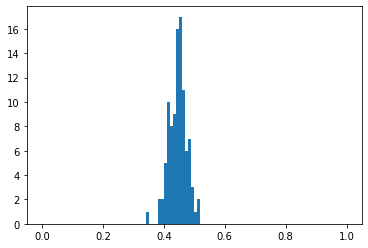

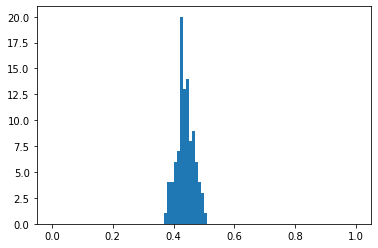

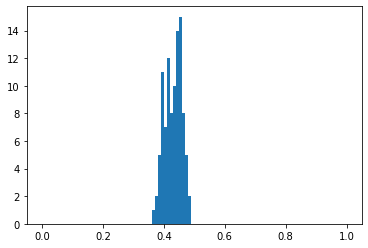

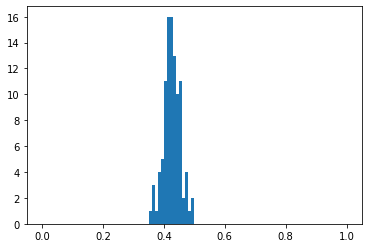

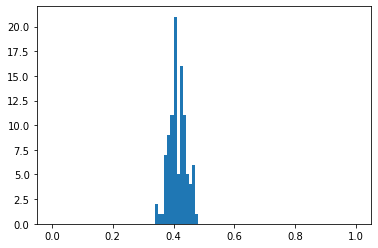

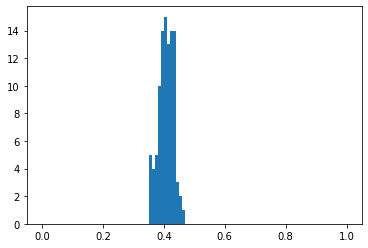

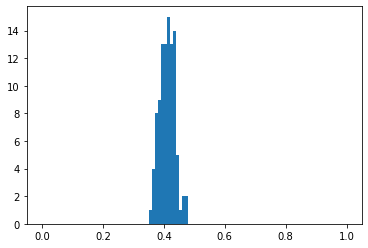

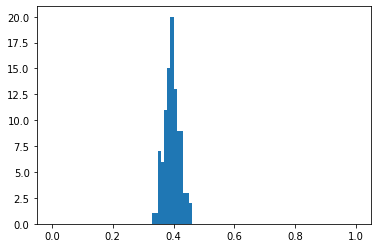

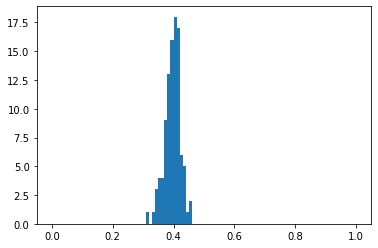

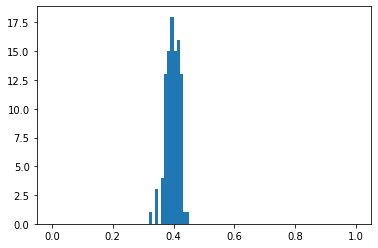

In [40]:
for i in range(10):
  print(i+1, end="\r")
  model.train(tagged_data, epochs=50, total_examples=model.corpus_count, callbacks=[])
  dotprodstl = []
  for j in range(100):
    test_doc = ["tomate"]
    random.seed(42)
    a = model.infer_vector(test_doc)
    random.seed(42)
    test_doc = ["livro"]
    b = model.infer_vector(test_doc)
    dotprodstl += [cos_sim(a,b)]
  plt.hist(dotprodstl, bins=100, range=(0,1))
  plt.show()


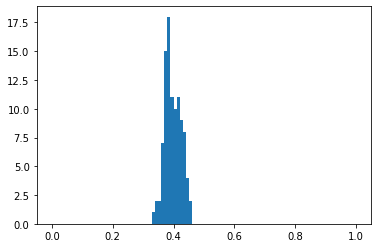

In [41]:
dotprodstl = []
for i in range(100):
  test_doc = ["tomate"]
  random.seed(42)
  a = model.infer_vector(test_doc)
  random.seed(42)
  test_doc = ["livro"]
  b = model.infer_vector(test_doc)
  dotprodstl += [cos_sim(a,b)]
plt.hist(dotprodstl, bins=100, range=(0,1))
plt.show()

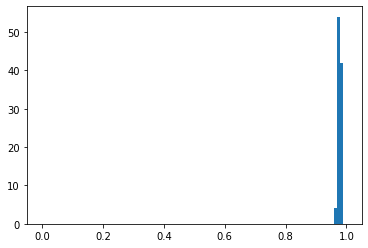

In [42]:
dotprodstt = []
for i in range(100):
  test_doc = ["tomate"]
  a = model.infer_vector(test_doc)
  test_doc = ["tomate"]
  b = model.infer_vector(test_doc)
  dotprodstt += [cos_sim(a,b)]
plt.hist(dotprodstt, bins=100, range=(0,1))
plt.show()

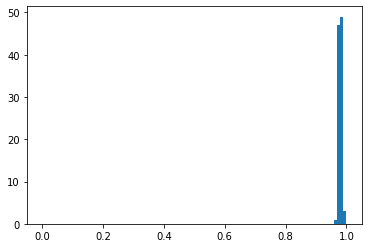

In [43]:
dotprodsll = []
for i in range(100):
  test_doc = ["livro"]
  a = model.infer_vector(test_doc)
  test_doc = ["livro"]
  b = model.infer_vector(test_doc)
  dotprodsll += [cos_sim(a,b)]
plt.hist(dotprodsll, bins=100, range=(0,1))
plt.show()

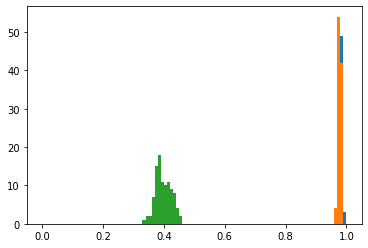

In [44]:
plt.hist(dotprodsll, bins=100, range=(0,1))
plt.hist(dotprodstt, bins=100, range=(0,1))
plt.hist(dotprodstl, bins=100, range=(0,1))
plt.show()

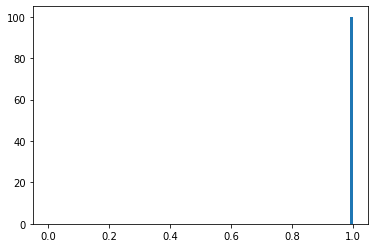

In [45]:
dotprodstl = []
for i in range(100):
  test_doc = ["lacasfds"]
  a = model.infer_vector(test_doc)
  test_doc = ["lacasfds"]
  b = model.infer_vector(test_doc)
  dotprodstl += [cos_sim(a,b)]
plt.hist(dotprodstl, bins=100, range=(0,1))
plt.show()

In [46]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def reduce_dimensions3D(model):
    num_dimensions = 3  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    z_vals = [v[2] for v in vectors]
    return x_vals, y_vals, z_vals, labels



def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 50)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


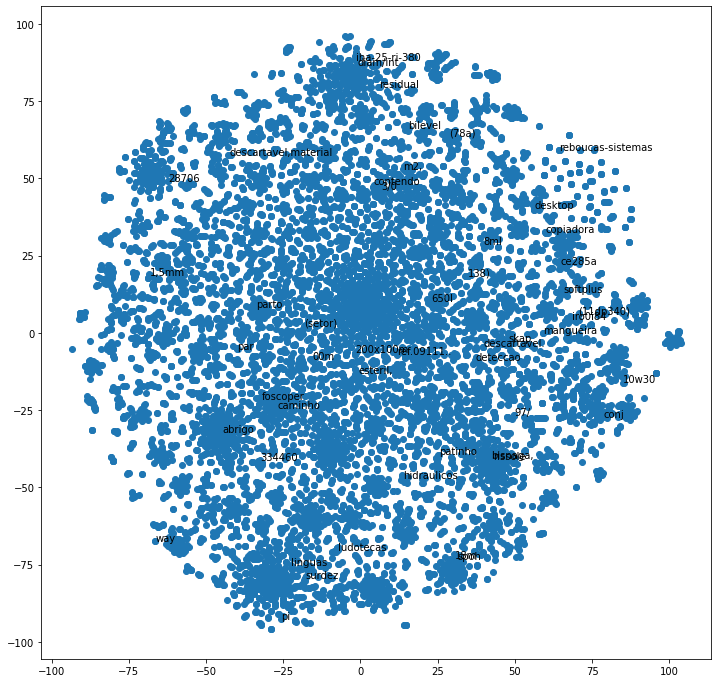

In [47]:
x_vals, y_vals, labels = reduce_dimensions(model)
plot_function = plot_with_matplotlib
plot_function(x_vals, y_vals, labels)

In [48]:
if False:
  x_vals, y_vals, z_vals, labels = reduce_dimensions3D(model)
#plot_function = plot_with_matplotlib
#plot_function(x_vals, y_vals, labels)

In [49]:
if False:
  fig = plt.figure(figsize=(20,20))
  ax = fig.add_subplot(projection='3d')

  n = 100

  ax.scatter(x_vals, y_vals, z_vals)

  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  indices = list(range(len(labels)))
  selected_indices = random.sample(indices, 50)
  for i in selected_indices:
    ax.text(x_vals[i], y_vals[i], z_vals[i], labels[i])

  plt.show()

In [50]:
model.train(tagged_data, epochs=200, total_examples=model.corpus_count, callbacks=[callback()])

Loss after epoch 0: 0.0
Loss after epoch 1: 0.0
Loss after epoch 2: 0.0
Loss after epoch 3: 0.0
Loss after epoch 4: 0.0
Loss after epoch 5: 0.0
Loss after epoch 6: 0.0
Loss after epoch 7: 0.0
Loss after epoch 8: 0.0
Loss after epoch 9: 0.0
Loss after epoch 10: 0.0
Loss after epoch 11: 0.0
Loss after epoch 12: 0.0
Loss after epoch 13: 0.0
Loss after epoch 14: 0.0
Loss after epoch 15: 0.0
Loss after epoch 16: 0.0
Loss after epoch 17: 0.0
Loss after epoch 18: 0.0
Loss after epoch 19: 0.0
Loss after epoch 20: 0.0
Loss after epoch 21: 0.0
Loss after epoch 22: 0.0
Loss after epoch 23: 0.0
Loss after epoch 24: 0.0
Loss after epoch 25: 0.0
Loss after epoch 26: 0.0
Loss after epoch 27: 0.0
Loss after epoch 28: 0.0
Loss after epoch 29: 0.0
Loss after epoch 30: 0.0
Loss after epoch 31: 0.0
Loss after epoch 32: 0.0
Loss after epoch 33: 0.0
Loss after epoch 34: 0.0
Loss after epoch 35: 0.0
Loss after epoch 36: 0.0
Loss after epoch 37: 0.0
Loss after epoch 38: 0.0
Loss after epoch 39: 0.0
Loss after

In [51]:
len(text_corpus)

5000

In [52]:
sampled_corpus = random.sample(text_corpus, 5000)
vecs = [ model.infer_vector(_.lower()) for _ in sampled_corpus ]

tsne = TSNE(n_components=3, random_state=0)
vectors = tsne.fit_transform(vecs)

x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]
z_vals = [v[2] for v in vectors]
labels = sampled_corpus

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


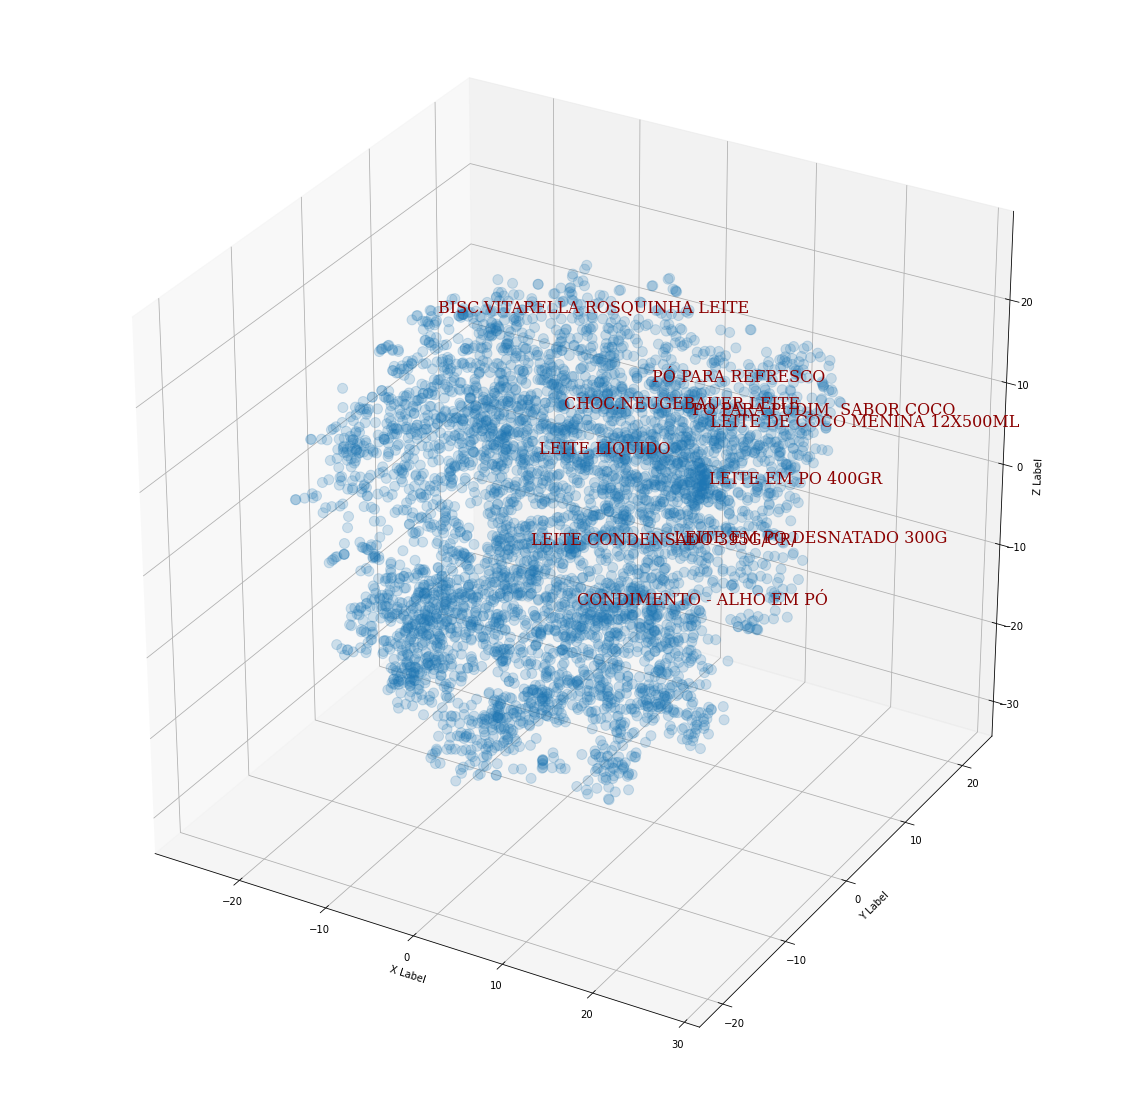

In [61]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,}
        
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_vals, y_vals, z_vals, alpha=0.2, s=100)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

indices = list(range(len(labels)))
#selected_indices = random.sample(indices, 10)
#choice = random.randint(0,len(vecs)-1)

#Talvez com distância do cosseno fique melhor
choice = 400

#EUCLIDEAN
#selected_indices = np.argsort(((vecs[choice]-np.array(vecs))**2).sum(axis=-1))[:5]

#COSSINE
selected_indices = np.argsort(np.array(vecs).dot(vecs[choice])/(norm(vecs, axis=-1)*norm(vecs[choice])))[::-1][:5]

test_doc = word_tokenize("leite em pó".lower())
#test_doc = word_tokenize("refrigerante coca-cola".lower())
#test_doc = word_tokenize("banana caturra".lower())
test_doc_vector = model.infer_vector(test_doc)
#selected_indices = np.argsort(np.array(vecs).dot(test_doc_vector)/(norm(vecs, axis=-1)*norm(test_doc_vector)))[::-1][:5]
#selected_indices = np.argsort(((test_doc_vector-np.array(vecs))**2).sum(axis=-1))[:3]

test = model.docvecs.most_similar(positive = [test_doc_vector])
idxs = [_[0] for _ in test]
centers = tsne.fit_transform(np.array([model.infer_vector(text_corpus[_].lower()) for _ in idxs]))
#for i, [x,y,z] in zip(idxs, centers):
#  ax.text(x, y, z, text_corpus[i], fontdict=font)
#  print(i,x,y,z)

selected_indices = [_[0] for _ in test]

for i in selected_indices:
  ax.text(x_vals[i], y_vals[i], z_vals[i], text_corpus[i], fontdict=font)

plt.show()

In [ ]:
centers

In [ ]:
selected_indices

In [ ]:
tsne.fit_transform()